In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cantera as ct
print('Running Cantera version: ' + ct.__version__)

#from inputs import *

Running Cantera version: 3.1.0


### Define $T_{ign}$ evaluation function

Define the ignition delay time (IDT). This function computes the ignition
delay from the occurrence of the peak concentration for the specified species.

In [23]:
def ignition_delay(states, species:str):
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

## IDT calculation



In [24]:
gas = ct.Solution('aramco3.yaml')
gas.TP = 750, 24 * ct.one_atm
# NOTE We evaluate T_ign at phi=1 for worst case.
gas.set_equivalence_ratio(phi=1.0, fuel={'CH4':0.95, 'H2':0.5},
                               oxidizer={'O2': 1.0, 'N2': 3.76})


r = ct.Reactor(contents=gas)
reactor_network = ct.ReactorNet([r])
time_history_RG = ct.SolutionArray(gas, extra=['t'])

t_ign_est = 0.75

t = 0
t0 = time.time()
counter = 1
while t < t_ign_est:
    t = reactor_network.step()
    if counter % 10 == 0:
        time_history_RG.append(r.thermo.state, t=t)
    counter += 1

tau_ign = ignition_delay(time_history_RG, 'OH')

t1 = time.time()
print("Computed Ignition Delay: {:.3e} seconds. "
      "Took {:3.2f} s to compute".format(tau_ign, t1-t0))

Computed Ignition Delay: 6.409e-01 seconds. Took 0.23 s to compute


## Plot the results



In [25]:
plt.rcParams['figure.constrained_layout.use'] = True

plt.figure()
plt.plot(time_history_RG.t, time_history_RG('oh').Y)
plt.xlabel('Time (s)')
plt.ylabel(r'OH mass fraction, $\mathdefault{Y_{OH}}$')

ax = plt.gca()
ax.annotate("", xy=(tau_ign, 0.005), xytext=(0, 0.005),
           arrowprops=dict(arrowstyle="<|-|>", color='k', linewidth=2.0))
plt.annotate(f'Ignition Delay Time = {tau_ign:.3f}s', xy=(0, 0), xytext=(0.00008, 0.00525))

plt.legend([r"$Y_{OH}$"])

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: typing.SupportsInt, height: typing.SupportsInt, dpi: typing.SupportsFloat)

Invoked with: 570, 1498581783130, 100.0

<Figure size 640x480 with 1 Axes>

In [10]:
import cantera as ct
import numpy as np
import scipy.integrate


class ReactorOde:
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density

        wdot = self.gas.net_production_rates
        dTdt = - (np.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        dYdt = wdot * self.gas.molecular_weights / rho

        return np.hstack((dTdt, dYdt))

dir = os.getcwd()
mech = os.path.join(dir, 'ar22.yaml')
gas = ct.Solution(mech)

# Initial condition
P = 24 * ct.one_atm
gas.TP = 750, P
gas.set_equivalence_ratio(phi=1.0, fuel={'CH4':1.0},
                               oxidizer={'O2': 1.0, 'N2': 3.76})
y0 = np.hstack((gas.T, gas.Y))

# Set up objects representing the ODE and the solver
ode = ReactorOde(gas)
solver = scipy.integrate.ode(ode)
solver.set_integrator('vode', method='bdf', with_jacobian=True)
solver.set_initial_value(y0, 0.0)

# Integrate the equations, keeping T(t) and Y(k,t)
t_end = 4
states = ct.SolutionArray(gas, 1, extra={'t': [0.0]})
dt = 1e-5
while solver.successful() and solver.t < t_end:
    solver.integrate(solver.t + dt)
    gas.TPY = solver.y[0], P, solver.y[1:]
    states.append(gas.state, t=solver.t)


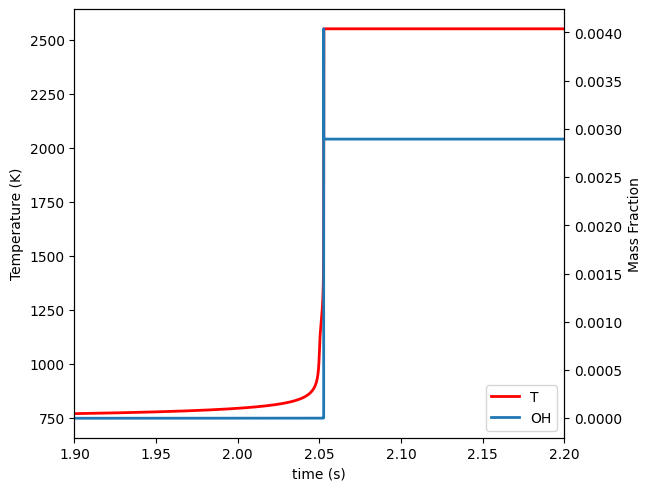

In [11]:
import matplotlib.pyplot as plt

L1 = plt.plot(states.t, states.T, color='r', label='T', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.xlim(1.9, 2.2)
plt.twinx()
L2 = plt.plot(states.t, states('OH').Y, label='OH', lw=2)
plt.ylabel('Mass Fraction')
plt.legend(L1+L2, [line.get_label() for line in L1+L2], loc='lower right')


plt.savefig("ignition_delay.pdf")
plt.show()

In [12]:
import cantera as ct
gas_ch = ct.Solution('aramco3.yaml')




In [13]:
gas_ch.TPX = 325, ct.one_atm, {'CH4':1.0}
print(gas_ch.report())
print(gas_ch.density)


  gas:

       temperature   325 K
          pressure   1.0132e+05 Pa
           density   0.60157 kg/m^3
  mean mol. weight   16.043 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -4.5894e+06       -7.3627e+07  J
   internal energy       -4.7578e+06       -7.6329e+07  J
           entropy             11812        1.8949e+05  J/K
    Gibbs function       -8.4281e+06       -1.3521e+08  J
 heat capacity c_p            2292.5             36778  J/K
 heat capacity c_v            1774.2             28464  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               CH4                 1                 1           -50.038
     [ +580 minor]                 0                 0  

0.6015678942750146
